In [135]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Python packages
"""

import numpy as np
from scipy import stats, optimize
import pandas as pd
import matplotlib.pyplot as plt

"""
Own packages
"""

from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();


# Views
from codelib.portfolio_optimization.views import ViewType, ProbabilitySolver, MeanView, VolatilityView

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fully Flexible Views

## Entropy minimization 

[Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) presents how we can incorporate views on all moments such as the mean, standard devation and correlation. The views are applicable even in non-normal markets. 

The approach applies Relative Entropy Minimization (REM). The goal is to find a distribution that satisfies our views while being as close as possible to the prior distribution. Closeness is quantified by the [relative entropy](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence): 
$$
\mathcal{E} (\tilde{f}_{\mathbf{X}}, f_{\mathbf{X}}) = \intop \tilde{f}_{\mathbf{X}} \left[\ln \tilde{f}_{\mathbf{X}} - \ln f_{\mathbf{X}}  \right] dx
$$
where $f_{\mathbf{X}}$ is the reference or prior distribution and  $\tilde{f}_{\mathbf{X}}$ is a generic distribution which aligns with our view. 

So basically, we need to minimize the relative entropy
$$
\tilde{f}_{\mathbf{X}} \equiv \underset{f \in \mathbb{V}}{\text{argmin }} \mathcal{E} (\tilde{f}_{\mathbf{X}}, f_{\mathbf{X}})
$$
where $f \in \mathbb{V}$ stands for all the distributions consistent with the views. We will label the solution to the above minimization problem as the full confidence posterior.  

__Example: Plotting the relative entropy__

To get a better felling of the relative entropy, we will assume that we have a "prior" distribution 
$$
X \sim  N(0, 1)
$$
and a "view" distribution
$$
Y  \sim N(0.5, 1)
$$
First, we plot the two density functions 


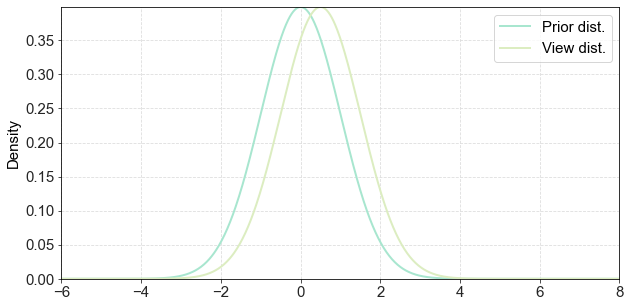

In [136]:
mu_prior = 0
sigma_prior = 1

mu_view = 0.5
sigma_view = 1

eval_values = np.linspace(-6, 8, 1000)
prior_pdf = stats.norm.pdf(eval_values, mu_prior, sigma_prior)
view_pdf = stats.norm.pdf(eval_values, mu_view, sigma_view)

"""
Plottting
"""

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(eval_values, prior_pdf, label='Prior dist.')
ax.plot(eval_values, view_pdf, label='View dist.')
ax.legend();
ax.set_ylabel('Density');

Next, we plot the cumulative relative entropy. 

In [137]:
log_pdf_diff = lambda x: stats.norm.logpdf(x, mu_view, sigma_view) -  stats.norm.logpdf(x, mu_prior, sigma_prior)
entropy_eval = np.linspace(-6, 8, 100)
cum_entropy = [stats.norm.expect(log_pdf_diff, args=(), loc=mu_view, scale=sigma_view, lb=-np.inf, ub=_)
               for _ in entropy_eval]

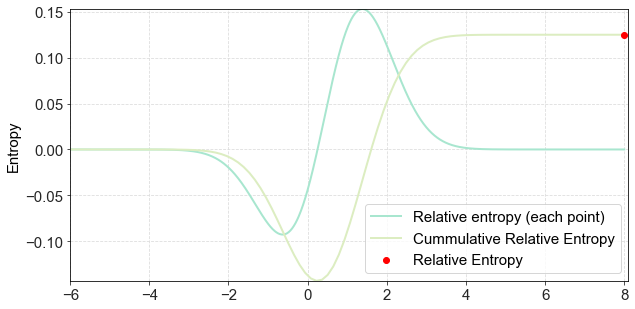

In [138]:
"""
Plotting
"""

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(eval_values, view_pdf * log_pdf_diff(eval_values), label='Relative entropy (each point)')
ax.plot(entropy_eval, cum_entropy, label='Cummulative Relative Entropy')
ax.scatter(entropy_eval[-1], cum_entropy[-1],color="red", zorder=5, label="Relative Entropy")
ax.legend();
ax.set_ylabel('Entropy');
ax.set_xlim([-6, 8.1]);

The objective will be to minimize the value represented by the red dot (the total relative entropy) while our view is satisfied. 

### Confidence

Minimizing the relative entropy will give us the full confidence posterior $\tilde{f}_{\mathbf{X}}$. However, if we do not assign full confidence, then we shrink the posterior distribution towards the reference distribution using opinion-pooling
$$
\tilde{f}_{\mathbf{X}}^c = (1-c) f_{\mathbf{X}} + c \tilde{f}_{\mathbf{X}}
$$
with $c\in [0, 1]$. 

In a multiple portfolio manager context where each portfolio manager has full confidence in their views, we may find the posterior distribution as the confidence weighted average

$$
\tilde{f}_{\mathbf{X}}^c = \sum_{s=1}^S c_s \tilde{f}_{\mathbf{X}}^s
$$

## The normal case: An analytical formula for linear constraints

Generally, minimizing the relative entropy analytically is a daunting task and must therefore often be done numerically (more about this later). However, [Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) derives an analytical formula in the case where the prior distribution is normal and where the views are defined as linear transformations. 

If we assume that the prior or reference distribution of the vector random variable $\mathbf{X}$ is given by

$$
\mathbf{X} \sim N(\mu, \Sigma)
$$

and express views on expectations of linear combinantins $\mathbf{Q}\mathbf{X}$ and on the covariance of arbitrary, potentially different linear combinations $\mathbf{G}\mathbf{X}$ such that 

$$
\begin{align}
\tilde{\text{E}}[\mathbf{Q}\mathbf{X}] &\equiv \tilde{\mu}_Q \\
\tilde{\text{Cov}}[\mathbf{G}\mathbf{X}] &\equiv \tilde{\Sigma}_Q
\end{align}
$$

The full-confidence posterior distribution is also normal 

$$
\mathbf{X} \sim N(\tilde{\mu}, \tilde{\Sigma})
$$

where 

$$
\begin{align}
\tilde{\mu} &\equiv \mu + \Sigma \mathbf{Q}^\top \left( \mathbf{Q} \Sigma \mathbf{Q}^\top\right)(\tilde{\mu}_Q - \mathbf{Q}\mu)\\
\tilde{\Sigma} &\equiv \Sigma + \Sigma \mathbf{G}^\top \left((\mathbf{G}\Sigma \mathbf{G}^\top)^{-1} \tilde{\Sigma}_G (\mathbf{G}\Sigma \mathbf{G}^\top)^{-1}  - (\mathbf{G}\Sigma \mathbf{G}^\top)^{-1} \right) \mathbf{G} \Sigma
\end{align}
$$


__Example__

Assume that 

$$
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \sim N\left(\begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 1 & 0.8\\
0.8 & 1\end{bmatrix} \right)
$$

Implement the view $\text{E}[X_1] = 0.5$ and $\text{Sd}[X_1] = 0.1$. 

In [139]:
def calculate_mu_tilde(mu: np.ndarray, cov_mat: np.ndarray, mu_view: np.ndarray, q_matrix: np.ndarray) -> np.ndarray: 
    
    """
    Calculates the posterior expected values with an arbitrary linear combination E[QX] = mu_view, 
    when prior distribution is assumed normal N(mu, Sigma). 
    
    Parameters
    ----------
    
    mu: 
        Expected value vector of prior distribution.
    cov_mat:
        Covariance matrix of prior distribution.
    mu_view: 
        Expected values of the linear combinations QX.
    q_matrix: 
        Matrix defining the linear combinations.
    
    """
    
    mu_view = np.atleast_1d(mu_view)
    q_mat = np.atleast_2d(q_matrix) 
    q_mat_t = np.transpose(q_mat)
    
    mu_tilde = mu + cov_mat @ q_mat_t @ (q_mat @ cov_mat @ q_mat_t) @ (mu_view - q_mat @ mu)
    
    return mu_tilde


def calculate_sigma_tilde(cov_mat: np.array, cov_mat_view: np.array, g_matrix: np.array) -> np.ndarray: 
    
    """
    Calculates the posterior covariance matrix with the linear view Cov[GX] = cov_mat_view, when prior distribution 
    is assumed normal N(mu, Sigma). 
    
    Parameters
    ----------
    
    cov_mat:
        Covariance matrix of prior distribution.
    cov_mat_view: 
        Covariance of the linear combinations GX.
    g_matrix: 
        Matrix defining the linear combinations.
    
    """
    
    cov_mat_view = np.atleast_1d(cov_mat_view)
    
    g_mat = np.atleast_2d(g_matrix)
    g_mat_t = np.transpose(g_mat)
    
    gcovg_inv = np.linalg.inv(g_mat @ cov_mat @ g_mat_t)
    
    sigma_tilde = cov_mat + cov_mat @ g_mat_t @ (gcovg_inv @ cov_mat_view @ gcovg_inv - gcovg_inv) @ g_mat @ cov_mat
    
    return sigma_tilde

In [140]:
"""
Define input parameters
"""

mu = np.array([0.0, 0.0])
cov_mat = np.array([[1.0, 0.8],
                    [0.8, 1.0]])
q_mat = np.array([1.0, 0.0])
mu_view = np.array([0.5])

g_mat = np.array([1.0, 0.0])
cov_mat_view = 0.01

In [141]:
"""
Calculate parameters of posterior distribution
"""

mu_tilde = calculate_mu_tilde(mu, cov_mat, mu_view, q_mat)
sigma_tilde = calculate_sigma_tilde(cov_mat, cov_mat_view, g_mat)

In [142]:
mu_tilde

array([0.5, 0.4])

In [143]:
sigma_tilde

array([[0.01  , 0.008 ],
       [0.008 , 0.3664]])

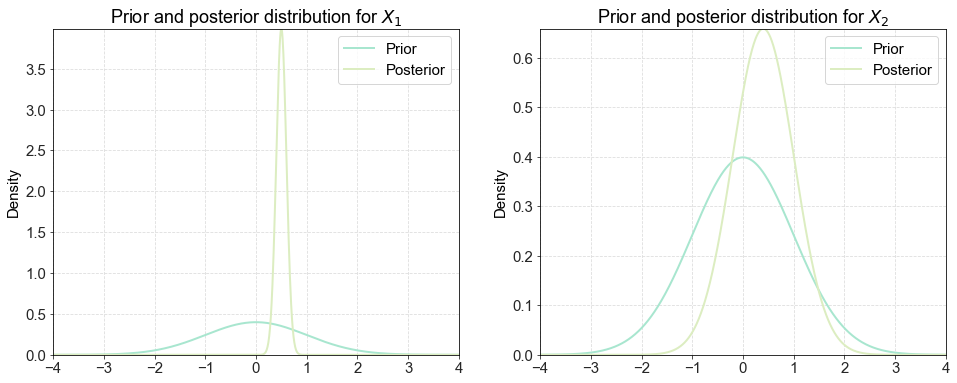

In [144]:
x_values = np.linspace(-4, 4, 1000)
norm_pdf_values = stats.norm.pdf(x_values)

fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].plot(x_values, norm_pdf_values, label="Prior")
ax[0].plot(x_values, stats.norm.pdf(x_values, loc=mu_tilde[0], scale=np.sqrt(sigma_tilde[0,0])), label="Posterior")
ax[0].legend();
ax[0].set_title('Prior and posterior distribution for $X_1$');
ax[0].set_ylabel('Density');

ax[1].plot(x_values, norm_pdf_values, label="Prior")
ax[1].plot(x_values, stats.norm.pdf(x_values, loc=mu_tilde[1], scale=np.sqrt(sigma_tilde[1, 1])), label="Posterior");
ax[1].legend();
ax[1].set_title('Prior and posterior distribution for $X_2$');
ax[1].set_ylabel('Density');

## Numerical implementation using simulations 

[Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) shows how we easily can implement views on any distribution by using a (large) panel of simulations as the reference model. Basically, we are using the empirical distribution function of the simulated data as the probability function of interest. 

We seek to represent the market $\mathbf{X}$ using a $J \times N$ panel of simulations, $\mathcal{X}$, and a $J \times 1$ vector, $\mathbf{p}$, of probabilities where $J$ refers to the number of simulations and $N$ refers to the number of variables. The entries of $\mathbf{p}$ representing the prior model will often all be equal to $1 / J $, but this is not a requirement. 

We will express constraints on generic non-linear functions of the market and we will gather them in a $J \times K$ panel $\mathcal{V}$ with entries defined as 
$$
\mathcal{V}_{j,k} \equiv g_k\left(\mathcal{X}_{j,1}, ..., \mathcal{X}_{j,N} \right)
$$
To find the posterior distribution $\tilde{\mathbf{p}}$ we need to minimize the relative entropy (now a discrete version)
$$
\mathcal{E}(\tilde{\mathbf{p}}, \mathbf{p}) \equiv \sum_{j=1}^J \tilde{p}_j [\ln \tilde{p}_j  - \ln p_j ]
$$
given our views. Following Attilio Meucci (2010) we note that it will be possible to implement large number of views using linear constraints on the yet to be determined probabilities
$$
\mathbf{b} \leq \mathbf{A} \tilde{\mathbf{p}} \leq \mathbf{c} 
$$
where $\mathbf{A}$, $\mathbf{b}$ and $\mathbf{c}$ are simple expression of $\mathcal{V}$. Notably, we can implement views on expectations using $\mathbf{A} = \mathcal{V}^\top$ and $\mathbf{b}=\mathbf{c}$. 

__Example__

Again, we assume that 
$$
\begin{bmatrix} X_1 \\ X_2 \end{bmatrix} \sim N\left(\begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 1 & 0.8\\
0.8 & 1\end{bmatrix} \right)
$$
How can we represent the views $\text{E}[X_1] = 0.5$ and $\text{Sd}[X_1] = 0.1$?

First, we let $J=10000$ and note that $N=2$. We can simply simulate the reference / prior model and represent it using the empirical distribution function. 

In [145]:
mu = np.array([0.0, 0.0])
cov_mat = np.array([[1.0, 0.8],
                    [0.8, 1.0]])

num_sim = 10000
prior_data = np.random.multivariate_normal(mu, cov_mat, size=num_sim)
init_probs = np.repeat(1.0 / num_sim, num_sim)

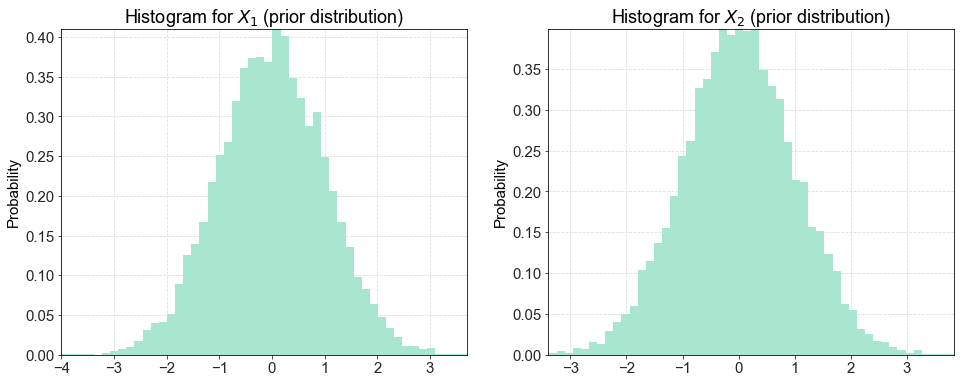

In [146]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

for i in range(2):
    ax[i].hist(prior_data[:, i], bins=50, density=True)
    ax[i].set_title('Histogram for $X_{}$ (prior distribution)'.format(i + 1))
    ax[i].set_ylabel('Probability');

We want to implement the two views $\text{E}[X_1] = 0.5$ and $\text{Sd}[X_1] = 0.1$. The first view can expressed simply as 
$$
\mathbf{x}_1^\top \tilde{\mathbf{p}} = \sum_{j=1}^J x_{1j} \tilde{p}_i = 0.5
$$
and the view on standard deviation can be expressed as (note that $\text{Var}[X] = E[X^2] - E[X]^2$)
$$
[\mathbf{x}_1 \odot \mathbf{x}_1]^\top \tilde{\mathbf{p}} = \sum_{j=1}^J x_{1j}^2 \tilde{p}_i = 0.1^2 + 0.5^2
$$

### A simple and computationally efficient algorithm 

[Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) suggests a simple and efficient algorithm for solving the constrained minimization problem
$$
\tilde{\mathbf{p}} = \underset{\mathbf{F} \mathbf{x} \leq \mathbf{f} \\ \mathbf{H} \mathbf{x} =\mathbf{h}}{\text{arg min}} \sum_{j=1}^J x_j [\ln x_j - \ln p_j]
$$
Note the small change of notation as the constraints representing the views have been split up into equality and inequality constraints. Furthermore, the constraint $\mathbf{x} \geq \mathbf{0}$ will automatically be satisfied. 

The Lagrangian for this problem read 
$$
\mathcal{L} = \mathbf{x}^\top [\ln \mathbf{x} - \ln \mathbf{p}]  + \boldsymbol{\lambda}^\top [\mathbf{F} \mathbf{x} - \mathbf{f}]+ \boldsymbol{\nu}^\top [\mathbf{H} \mathbf{x} - \mathbf{h}]
$$
where  $\boldsymbol{\lambda}$ and $\boldsymbol{\nu}$ are vectors of Lagrange multipliers. The first order conditions are given by 
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{x}} = \ln \mathbf{x} - \ln \mathbf{p} + 1 + \mathbf{F}^\top \boldsymbol{\lambda} + \mathbf{H}^\top \boldsymbol{\nu} = \mathbf{0}
$$
It follows directly that 
$$
\mathbf{x}(\boldsymbol{\lambda}, \boldsymbol{\nu}) = e^{\ln \mathbf{p} - 1 - \mathbf{F}^\top \boldsymbol{\lambda} - \mathbf{H}^\top \boldsymbol{\nu}}
$$
The [Lagrange dual function](https://en.wikipedia.org/wiki/Duality_(optimization)) is then given by 
$$
\mathcal{G}(\boldsymbol{\lambda}, \boldsymbol{\nu}) =  \mathcal{L}(\mathbf{x}(\boldsymbol{\lambda}, \boldsymbol{\nu}) , \boldsymbol{\lambda}, \boldsymbol{\nu})
$$
and the optimization problem can be restated as 
$$
\boldsymbol{\lambda}^*, \boldsymbol{\nu}^* = \underset{\boldsymbol{\lambda} \geq 0, \boldsymbol{\nu}}{\text{arg max }} \mathcal{G}(\boldsymbol{\lambda}, \boldsymbol{\nu}) 
$$
since the optimal Lagrange multipliers follow from maximization of the Lagrange dual function. Finally, we can calculate 
$$
\tilde{\mathbf{p}} = \mathbf{x}(\boldsymbol{\lambda}^*, \boldsymbol{\nu}^*) 
$$

__Example__

We now estimate the probabilities corresponding to the views from the previous example. We clearly see that the numerical solution closely matches the analytical solution for the normal case. 

In [147]:
def calculate_p_tilde(v, p, h_matrix):
    
    temp = np.log(p) - 1.0 - np.transpose(h_matrix) @ v
    
    return np.exp(temp)


def view_objective_function(v, p, h_matrix, h_vector):
    
    x = calculate_p_tilde(v, p, h_matrix)
    x = np.maximum(x,10**(-32))
    
    lagrangian = x.T @ (np.log(x) - np.log(p)) + v @ (h_matrix @ x - h_vector)
    
    return -lagrangian

In [148]:
# we add the constraint that the weights need to sum to one 
# view matrix
h_matrix = np.vstack((np.ones(num_sim), prior_data[:, 0], prior_data[:, 0]*prior_data[:, 0]))

# view vector 
second_moment = 0.01 + 0.5**2
h_vector = np.array([1.0, 0.5, second_moment])

# maximize dual lagrangian 
res = optimize.minimize(view_objective_function, [0.0, 0.0, 0.0], args=(init_probs, h_matrix, h_vector))

# calculate p tilde
p_tilde = calculate_p_tilde(res.x, init_probs, h_matrix)

In [149]:
np.sum(p_tilde)

1.0000062530782616

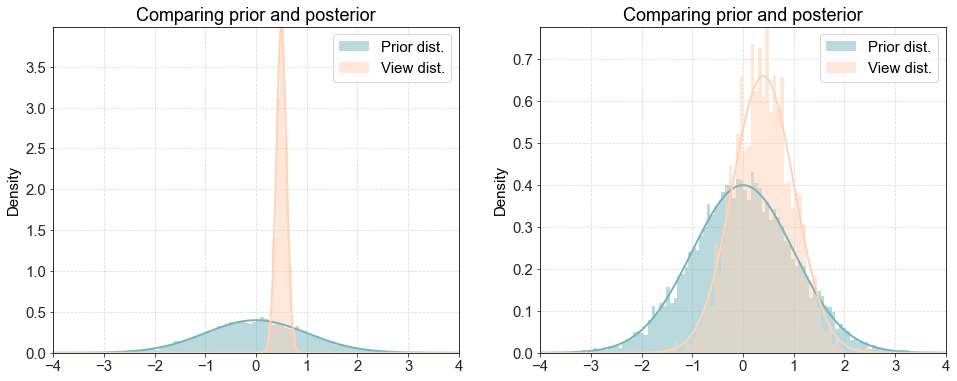

In [150]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

for i in range(2):
    ax[i].hist(prior_data[:, i], bins=100, density=True, alpha=0.5, label="Prior dist.",
               color=default_colors['cyan'])
    ax[i].plot(x_values, stats.norm.pdf(x_values, loc=mu[i], scale=np.sqrt(cov_mat[i, i])),
               color=default_colors['cyan']);
    ax[i].hist(prior_data[:, i], bins=100, weights=p_tilde, density=True, alpha=0.5, label="View dist.",
               color=default_colors['orange']);
    ax[i].plot(x_values, stats.norm.pdf(x_values, loc=mu_tilde[i], scale=np.sqrt(sigma_tilde[i, i])),
               color=default_colors['orange']);
    ax[i].set_title('Comparing prior and posterior'.format(i + 1))
    ax[i].set_ylabel('Density');
    ax[i].legend();
    

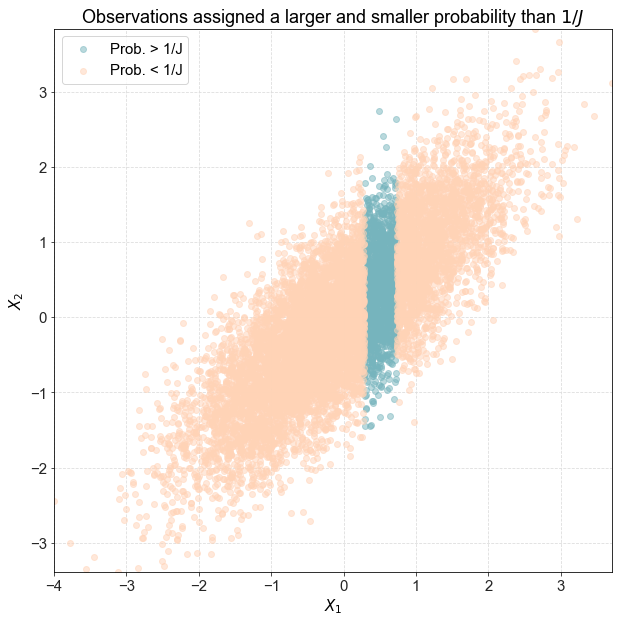

In [151]:
indicator = (p_tilde > 1.0 / num_sim)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(prior_data[indicator, 0], prior_data[indicator, 1], alpha=0.5,
            color=default_colors['cyan'], label="Prob. > 1/J")
ax.scatter(prior_data[~indicator, 0], prior_data[~indicator, 1], alpha=0.5,
            color=default_colors['orange'], label="Prob. < 1/J")

ax.legend(); 
ax.set_xlabel('$X_1$');
ax.set_ylabel('$X_2$');
ax.set_title('Observations assigned a larger and smaller probability than $1 / J$');

In [152]:
"""
Class that implements the above method
"""

mean_view = MeanView(ViewType.Equality, prior_data[:, 0], 0.5)
vol_view = VolatilityView(ViewType.Equality, prior_data[:, 0], 0.5, 0.1)

all_views = [mean_view, vol_view]

view_solver = ProbabilitySolver(init_probs, all_views)
view_probs = view_solver.minimize_entropy()

## Literature 

[Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325)